<a href="https://colab.research.google.com/github/lingchm/datascience/blob/master/exercises/low_rank_matrix_completion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Rank Matrix Completion

**Problem**

Given a matrix with missing entries, complete the matrix such that it is the lowest possible rank.

**Method**

We formulate the following "matrix LASSO" problem and solve using proximal-gradient algorithm

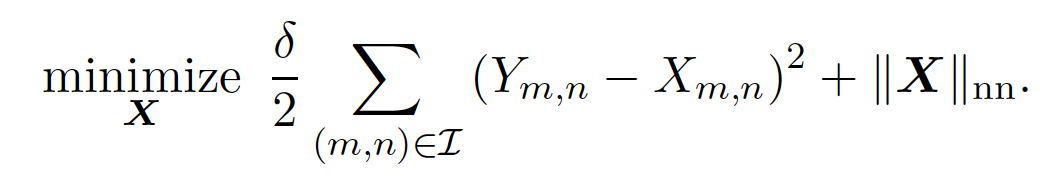


**References**
* https://gclinderman.github.io/blog/statistics/probability/matrix/completion/2018/07/08/matrix-completion.html


In [ ]:
import numpy as np

In [ ]:
# set up array 
Y = np.asarray([[10,  0,  0,  6,  4,  4, 12,  0],
       [12,  0,  6,  0,  6,  0, 18, 12],
       [ 0, 10,  4, 10,  0,  4,  0, 10],
       [ 0,  0,  2,  4,  0,  2,  6,  4],
       [ 0,  4,  2,  0,  0,  2,  6,  4],
       [10,  0,  4,  6,  0,  4, 12,  0],
       [10,  0,  4,  0,  4,  0, 12,  6],
       [ 6, 10,  0, 10,  4,  0, 12,  0]])
masked = np.asarray([[1, 0, 0, 1, 1, 1, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 1, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 0, 0, 1, 1, 1],
       [1, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 1, 0, 1, 0]])

In [ ]:
# implement proximal gradient algorithm
def prox_sn(Z):
    u, s, vh = np.linalg.svd(Z, full_matrices=False)
    for i in range(s.shape[0]): 
        if s[i] >= 1:
            s[i] = 1    
    s = np.diag(s)
    return u @ s @ vh
    
def prox_nn(Z, alpha):
    return Z - alpha * prox_sn(Z / alpha)
    
def gradf(delta, X, Y):
    return delta * (X - Y)

def proximal_gradient(Y, masked, alpha=0.01, delta=100, tol=1e-3, max_iter=10000):
    X0 = np.zeros(Y.shape)
    k, Xk, Xk_ = 0, X0, X0 + 1
    while np.linalg.norm(Xk - Xk_) > tol and k < max_iter:
        #f = delta / 2 * np.linalg.norm(Y - Xk)**2 + np.linalg.norm(Xk, ord='nuc')
        Xk_ = Xk * 1
        Xk = prox_nn(Xk - alpha * gradf(delta, Xk, Y) * masked, alpha)
        k += 1
        #print("Functional value:", f)
    print("Number of iterations:", k)
    return Xk

In [ ]:
# test
Y_ = proximal_gradient(Y, masked)
print("Estimated Y:")
print(np.round(Y_))
print("Rank", np.linalg.matrix_rank(Y_))

Number of iterations: 7376
Estimated Y:
[[10.  5.  4.  6.  4.  4. 12.  6.]
 [12. 11.  6. 12.  6.  6. 18. 12.]
 [ 6. 10.  4. 10.  4.  4. 12. 10.]
 [ 4.  4.  2.  4.  2.  2.  6.  4.]
 [ 4.  4.  2.  4.  2.  2.  6.  4.]
 [10.  5.  4.  6.  4.  4. 12.  6.]
 [10.  5.  4.  6.  4.  4. 12.  6.]
 [ 6. 10.  4. 10.  4.  4. 12. 10.]]
Rank 3
